# Audio discrimination task

## Extracting audio features

In [1]:
import librosa
import numpy as np
import os
from tqdm import tqdm

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()

    return np.hstack([mfccs, spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate])

bouba_dir = "data/audio/aug_audio/bouba/"
kiki_dir = "data/audio/aug_audio/kiki/"

data = []
labels = []

for file in tqdm(os.listdir(bouba_dir)):
    if file.endswith(".wav"):
        file_path = os.path.join(bouba_dir, file)
        features = extract_features(file_path)
        data.append(features)
        labels.append(0) # Bouba = 0

for file in tqdm(os.listdir(kiki_dir)):
    if file.endswith(".wav"):
        file_path = os.path.join(kiki_dir, file)
        features = extract_features(file_path)
        data.append(features)
        labels.append(1) # Kiki = 1

X = np.array(data)
y = np.array(labels)

print(f"{X.shape[0]} samples, {X.shape[1]} features per sample")

np.savez("data/audio/audio_features.npz", X=X, y=y)

100%|██████████████████████████████████████| 1500/1500 [00:09<00:00, 154.37it/s]

3000 samples, 17 features per sample


## Split dataset

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)



Training set shape: (2400, 17, 1)
Validation set shape: (600, 17, 1)


## Setup model

In [5]:
model_audio = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation="relu", input_shape=(X_train.shape[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(32, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

model_audio.compile(optimizer="adam",
                    loss="binary_crossentropy",
                    metrics=["accuracy"])

/Users/sidneyma/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training

In [6]:
epochs = 10
batch_size = 32

history_audio = model_audio.fit(X_train, y_train, validation_data=(X_val, y_val),
                                 epochs=epochs, batch_size=batch_size)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9031 - loss: 0.2333 - val_accuracy: 0.9133 - val_loss: 0.1736
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.9985 - loss: 0.0111 - val_accuracy: 0.9167 - val_loss: 0.1502
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.9977 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0256
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 1.0000 - loss: 5.9549e-04 - val_accuracy: 1.0000 - val_loss: 9.5789e-04
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 1.0000 - loss: 5.1165e-04 - val_ac

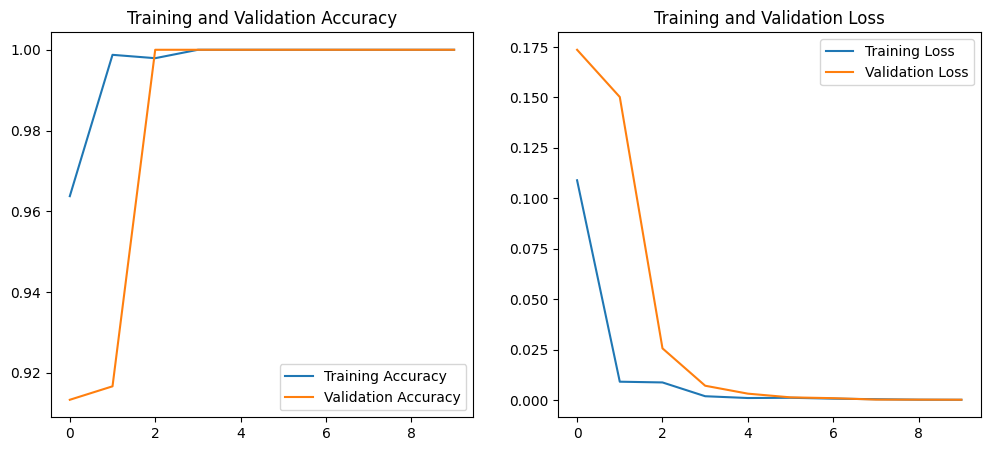

In [7]:
acc = history_audio.history['accuracy']
val_acc = history_audio.history['val_accuracy']
loss = history_audio.history['loss']
val_loss = history_audio.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 5))

# Accuracy plots
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend(loc="lower right")

# Loss plots
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend(loc="upper right")

plt.show()


In [8]:
# Save model
model_audio.save("models/audio_cnn.h5")

Audio model saved as 'audio_cnn.h5'
